# **Alternative Splicing  Heatplot**
This notebook generates a heat plot representing sex-biased differential gene expression as well as a plot showing the counts of differentially expressed genes per tissue.

The values in the heatmap represent the correlation (similarity in the fold-changes) between male and female samples, with the values in the heatmap being the correlation between the vectors of fold changes of the tissues.

The assumptions made before rendering the heatmaps 
1. Get differential gene expression (DGE) files
2. Use the ``../assets/tissues.tsv`` to limit the tissues to those with at least 50 samples in each sex (``tissues.tsv`` was produced by a Python script)
3. Use the pattern for the differentially expressed genes **"../data/*_AS_model_B_sex_as_events.csv"** to get all the values for the matrix.

## **Running this notebook**:

See the README for setting up prerequisites for the notebook.

## 1. Setup 

Assumes the `countGenesAndEvents.ipynb` notebook was run -- unpacking the results from the differential Gene Expression Analysis as run in the `differentialAlternativeSplicingJunctionAnalysis.ipynb` notebook.

In [1]:
start_time <- Sys.time()

suppressMessages({
    options(warn = -1) 
    library(stringr)
    library(edgeR)
    library(pheatmap)
    library(snakecase)
    Sys.setenv(TAR = "/bin/tar") # for gzfile
})

## 2. Making the matrices

### 2.1 Read in all the alternative Splicing Junction Analysis results

Start with the Skipped Exon alternative Splicing Junction Analysis results

In [2]:
results_dir <- "../data/"
pattern     <- "*_AS_model_B_sex_as_events_refined.csv"
files       <- list.files(path = results_dir, pattern = pattern)
message("Number of se AS files found with *AS_model_B_sex_as_events_refined.csv pattern: ",
        length(files))
se_files <- files[grepl("^se_", files)]
length(se_files)

Number of se AS files found with *AS_model_B_sex_as_events_refined.csv pattern: 195



[1] 39

### 2.2 read in the curated "../assets/tissues.tsv" 

The **`../assets/tissues.tsv`** file contains an indication to include the tissue if the file has at least **50** samples in that tissue with either **male** or **female** sex reporting

In [3]:
# read in all requirements so that the stage is properly set -- 
# if it is clear here -- it will remain clear for the rest of the time
# tissues.tsv contains the subset of files desired for analysis.
tissue_reduction <- read.table(file="../assets/tissues.tsv", header=TRUE, sep="\t",
                               skipNul=FALSE, stringsAsFactors = FALSE)
colnames(tissue_reduction)  <- c("SMTSD","female","male","include","display_name")
tissue_reduction$SMTSD <- factor(snakecase::to_snake_case(as.character(tissue_reduction$SMTSD)))
# only include those tissues we wish to continue with
table(tissue_reduction$include)
tissue_reduction <- tissue_reduction[tissue_reduction$include==1,]

message("Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)",
        paste(dim(tissue_reduction), collapse=" "))


 0  1 
11 39 

Number of tissues with >=50 samples each in ../assets/tissues.tsv (tissue_reduction)39 5



### 2.3 Heatmap gene-junction ids are union of events from all tissues

Junctions were removed for statistical requirements -- there are not the same number of results for all of the tissues.  As such we need to build the union of all the ids, order this and use this to enable making all of the matrices.

In [4]:
for (i in 1:length(se_files)) {
    fullfilename  <- paste0("../data/",se_files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    if (i == 1) {
        genesids <- filegenesids
    }
    genesids      <- union(as.character(genesids),filegenesids)
}
length(se_files)
idx <- str_order(genesids)
genesids <- genesids[idx]
length(genesids)
head(genesids)

[1] 39

[1] 213

[1] "ABCD4-4399"       "ABCD4-4404"       "ABCD4-4409"       "ABI1-35905"      
[5] "ABI1-35908"       "AC016629.3-27334"

### 2.4 With the union of gene-junction ids make a matrix of logFC and adjusted pValue data

all these results are already refined, i.e. logFC > log(1.5) and adjusted P-value < 0.05

In [5]:
files <- se_files
logFC_mat <- matrix(0.0, nrow=length(genesids), ncol = length(files))
rownames(logFC_mat) <- as.character(genesids)
for (i in 1:length(files)) {
    fullfilename  <- paste0("../data/",files[i])
    logFC_result  <- read.csv(fullfilename)
    filegenesids  <- as.character(rownames(logFC_result))
    # match the filegenesids in the list of unioned genesids for placing the significant gene-junction values
    # in the matrix where rows are gene-junctions and columns are tissues (filegenesids)
    for (j in 1:length(filegenesids)) {
        genesids_match <- genesids %in% filegenesids[j]
        logFC_mat[genesids_match==TRUE,i] <- logFC_result[filegenesids[j],"logFC"]
    }
}

mat_colnames = files
for (i in 1:length(mat_colnames)) {
    mat_colnames[i] <- gsub(pattern,"", mat_colnames[i], fixed = TRUE)
    mat_colnames[i] <- substring(mat_colnames[i],4)
}

display_name = ifelse(mat_colnames == tissue_reduction$SMTSD, 
                                      tissue_reduction$display_name,
                                      mat_colnames)
colnames(logFC_mat) <- as.character(display_name)

### 2.5 Calculate the correlation between the tissues using the logFC

Calculate the correlation distances between the tissues using the logFC within each of the tissues.   Clustering by similar expression.

In [6]:
dist_mat<-as.matrix(cor(logFC_mat))
colnames(dist_mat) <- as.character(tissue_reduction$display)
rownames(dist_mat) <- as.character(tissue_reduction$display)
head(dist_mat,2)

,Adipose (sc),Adipose (v),Adrenal gland,Aorta,Coronary artery,Tibial artery,Caudate,Cerebellar hemisphere,Cerebellum,Cortex,⋯,Tibial nerve,Pancreas,Pituitary,Skin (not exposed),Skin (exposed),Small intestine,Spleen,Stomach,Thyroid,Whole blood
Adipose (sc),1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Adipose (v),NA,1,NA,0.009268073,NA,NA,NA,NA,-0.0007242731,0.005574652,⋯,0.006566768,0.006566768,NA,NA,-0.0004557785,NA,-0.006566768,0.006566768,0.006566768,NA


In [7]:
sum(is.na(dist_mat))
sum(!is.na(dist_mat))
dist_mat_no_NA <- dist_mat
dist_mat_no_NA[is.na(dist_mat_no_NA)] = 0
sum(is.na(dist_mat_no_NA))
sum(!is.na(dist_mat_no_NA))
sum(dist_mat_no_NA <0)
dist_mat_no_NA_NZ <- dist_mat_no_NA
dist_mat_no_NA_NZ[dist_mat_no_NA_NZ <0] = 0
sum(dist_mat_no_NA_NZ <0)
sum(dist_mat_no_NA_NZ >0)
base_mean = rowMeans(dist_mat_no_NA_NZ)
base_mean

[1] 1210

[1] 311

[1] 0

[1] 1521

[1] 98

[1] 0

[1] 213

Adipose (sc)           Adipose (v)         Adrenal gland 
           0.02564103            0.02804887            0.02564103 
                Aorta       Coronary artery         Tibial artery 
           0.12412359            0.02564103            0.02564103 
              Caudate Cerebellar hemisphere            Cerebellum 
           0.02564103            0.02564103            0.02583179 
               Cortex        Frontal cortex           Hippocampus 
           0.02616846            0.02564103            0.02564103 
         Hypothalamus     Nucleus accumbens               Putamen 
           0.02564103            0.02626233            0.02564103 
          Spinal cord                Breast           Fibroblasts 
           0.02564103            0.03502229            0.02564103 
      EBV-lymphocytes         Sigmoid colon      Transverse colon 
           0.02737060            0.07758699            0.03658536 
      Esophagus (gej)         Esophagus (m)        Esophagus (mu) 
           0.13377493            0.02564103            0.08780852 
     Atrial appendage        Left ventricle                 Liver 
           0.02564103            0.02564103            0.02564103 
                 Lung       Skeletal muscle          Tibial nerve 
           0.02564103            0.02564103            0.13377493 
             Pancreas             Pituitary    Skin (not exposed) 
           0.04199941            0.02564103            0.02564103 
       Skin (exposed)       Small intestine                Spleen 
           0.09684046            0.02564103            0.02737060 
              Stomach               Thyroid           Whole blood 
           0.02626233            0.13377493            0.02564103

## 3. Render the heatmaps of the distance correlations

### 3.1 heatmap dist_mat_no_NA_NZ

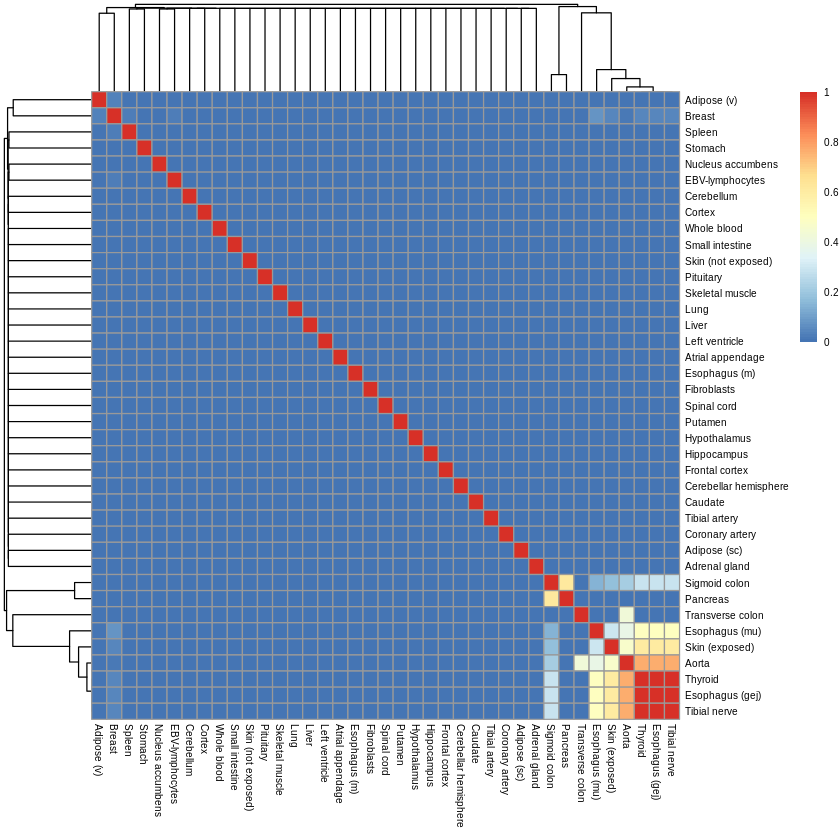

In [8]:
pheatmap(as.matrix(dist_mat_no_NA_NZ), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat_no_NA_NZ, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationHeatmapAlllogFC.pdf"))

### 3.2 heatmap normalize quantiles dist_mat_no_NA_NZ

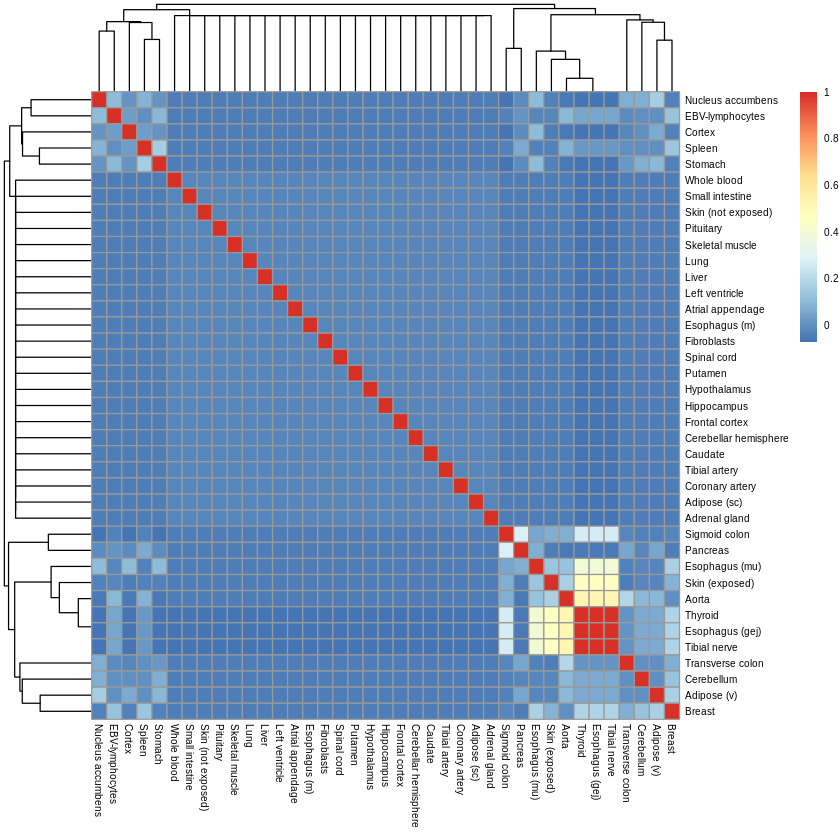

In [9]:
dist_mat_NQ <- normalizeQuantiles(dist_mat_no_NA_NZ)
dist_mat <- as.matrix(cor(dist_mat_NQ))
pheatmap(as.matrix(dist_mat), clustering_distance_rows = "correlation", clustering_distance_cols = "correlation", fontsize = 6)
hm.parameters <- list(dist_mat, fontsize = 6)
do.call("pheatmap", c(hm.parameters,  filename="../pdf/se_alternativeSplicingDistanceCorrelationAlllogFC_NQ.pdf"))

## Appendix Metadata

For replicability and reproducibility purposes, we also print the following metadata:

### Appendix.1. Checksums with the sha256 algorithm
1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [10]:
figure_id   = "alternativeSplicingHeatmap"

### Appendix.2. Libraries

In [11]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../data/", figure_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../data/", figure_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../data/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../data/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 4.0.5 (2021-03-31)
 os       Ubuntu 18.04.4 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2021-05-21                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
edgeR,edgeR,3.32.1,3.32.1,/opt/conda/envs/sbas/lib/R/library/edgeR,/opt/conda/envs/sbas/lib/R/library/edgeR,TRUE,FALSE,2021-01-14,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
limma,limma,3.46.0,3.46.0,/opt/conda/envs/sbas/lib/R/library/limma,/opt/conda/envs/sbas/lib/R/library/limma,TRUE,FALSE,2020-10-27,Bioconductor,NA,/opt/conda/envs/sbas/lib/R/library
pheatmap,pheatmap,1.0.12,1.0.12,/opt/conda/envs/sbas/lib/R/library/pheatmap,/opt/conda/envs/sbas/lib/R/library/pheatmap,TRUE,FALSE,2019-01-04,CRAN (R 4.0.0),NA,/opt/conda/envs/sbas/lib/R/library
snakecase,snakecase,0.11.0,0.11.0,/opt/conda/envs/sbas/lib/R/library/snakecase,/opt/conda/envs/sbas/lib/R/library/snakecase,TRUE,FALSE,2019-05-25,CRAN (R 4.0.0),NA,/opt/conda/envs/sbas/lib/R/library
stringr,stringr,1.4.0,1.4.0,/opt/conda/envs/sbas/lib/R/library/stringr,/opt/conda/envs/sbas/lib/R/library/stringr,TRUE,FALSE,2019-02-10,CRAN (R 4.0.0),NA,/opt/conda/envs/sbas/lib/R/library


In [12]:
end_time <- Sys.time()
end_time - start_time

Time difference of 2.847841 secs